### Esercitazione 15 - ATR (Average True Range)
#### Argomenti

* indicatore ATR
* implementazione di una strategia che sfrutti RSI e ATR

L'indicatore ATR (Average True Range) effettua una media mobile sui prezzi di uno strumento finanziario calcolati,
per ogni candela, prendendo il valore massimo tra:
* High - Low
* High - Close precedente (preso in valore assoluto)
* Low - Close precedente (preso in valore assoluto)

misurando così la volatilità del mercato sottostante. L'indicatore non indica la direzione del prezzo.

In [1]:
import pandas_datareader as pdr  # pip install pandas-datareader
from datetime import datetime
import numpy as np
import pandas as pd
import mplfinance as mpf
import talib

In [2]:
start = datetime(2020, 1, 1)
candles = pdr.get_data_yahoo("NFLX", start)

candles.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-11-30,308.260010,280.410004,281.369995,305.529999,16056500,305.529999
2022-12-01,319.799988,303.029999,303.989990,316.950012,14664900,316.950012
2022-12-02,321.989990,310.000000,310.489990,320.410004,12683500,320.410004
2022-12-05,322.769989,310.920013,316.459991,312.589996,8423000,312.589996
2022-12-06,313.220001,303.130005,311.000000,305.559998,7190200,305.559998


#### Prezzo di chiusura rettificato

I valori delle azioni sono espressi in termini di prezzo di chiusura e prezzo di chiusura rettificato.
Il **prezzo di chiusura** è il prezzo grezzo, che è solo il valore in contanti dell'ultimo prezzo negoziato
prima della chiusura del mercato. Il **prezzo di chiusura rettificato** tiene conto di tutto ciò che potrebbe
influenzare il prezzo delle azioni dopo la chiusura del mercato.

Il prezzo di un'azione è in genere influenzato dalla domanda e dall'offerta dei partecipanti al mercato.
Le rettifiche al prezzo di chiusura consentono agli investitori di ottenere una registrazione accurata della
performance del titolo. È particolarmente utile quando si esaminano i rendimenti storici perché offre agli analisti
una rappresentazione accurata del valore del capitale proprio dell'azienda.

In [3]:
# calcolo dell'ATR

time_period = 5 # default = 14

high_low = candles['High'] - candles['Low']
high_close = np.abs(candles['High'] - candles['Close'].shift())
low_close = np.abs(candles['Low'] - candles['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
candles['atr'] = true_range.rolling(time_period).sum()/time_period

candles.tail()

,High,Low,Open,Close,Volume,Adj Close,atr
Date,,,,,,,
2022-11-30,308.260010,280.410004,281.369995,305.529999,16056500,305.529999,11.985992
2022-12-01,319.799988,303.029999,303.989990,316.950012,14664900,316.950012,13.597992
2022-12-02,321.989990,310.000000,310.489990,320.410004,12683500,320.410004,14.529993
2022-12-05,322.769989,310.920013,316.459991,312.589996,8423000,312.589996,15.095990
2022-12-06,313.220001,303.130005,311.000000,305.559998,7190200,305.559998,15.709991


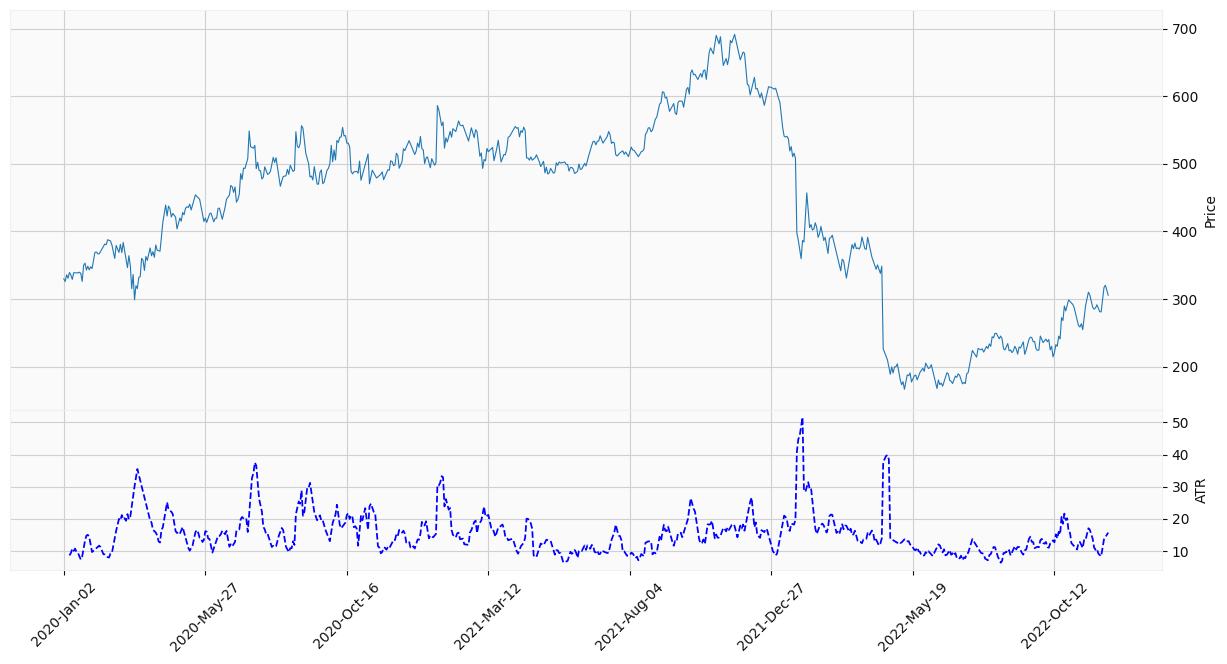

In [4]:
# visualizzazione dell'ATR

atr_plot = mpf.make_addplot(candles['atr'], color='blue', linestyle='--', panel=1, ylabel='ATR')
mpf.plot(candles, addplot=atr_plot, type='line', style='yahoo', figsize=(16, 8))

In [5]:
# aggiungiamo l'RSI al nostro dataset per poter implementare successivamente una strategia che lo sfrutti
candles['rsi'] = talib.RSI(candles['Close'], timeperiod=time_period)
candles['rsi_1'] = candles['rsi'].shift(1)

candles.tail()

,High,Low,Open,Close,Volume,Adj Close,atr,rsi,rsi_1
Date,,,,,,,,,
2022-11-30,308.260010,280.410004,281.369995,305.529999,16056500,305.529999,11.985992,72.881224,37.324914
2022-12-01,319.799988,303.029999,303.989990,316.950012,14664900,316.950012,13.597992,79.603877,72.881224
2022-12-02,321.989990,310.000000,310.489990,320.410004,12683500,320.410004,14.529993,81.354391,79.603877
2022-12-05,322.769989,310.920013,316.459991,312.589996,8423000,312.589996,15.095990,65.477889,81.354391
2022-12-06,313.220001,303.130005,311.000000,305.559998,7190200,305.559998,15.709991,53.701363,65.477889


In [6]:
# implementazione di una strategia basata su RSI per entrare su una posizione e che sfrutti l'ATR per
# capire quando chiuderla

operazioni = []
posizione = 0

for ts, c in candles.iterrows():
    if posizione == 0:
        if c.rsi < 75 and c.rsi > c.rsi_1:
            posizione = 1
            operazioni.append([ts, np.nan, posizione, c['Close'], np.nan])
            stop_loss = c['Close'] - 2 * c.atr
        if c.rsi > 25 and c.rsi < c.rsi_1:
            posizione = -1
            operazioni.append([ts, np.nan, posizione, c['Close'], np.nan])
            stop_loss = c['Close'] + 2 * c.atr
    else:
        if posizione == 1:
            if c['Close'] <= stop_loss:
                posizione = 0
                operazioni[-1][1] = ts
                operazioni[-1][4] = c['Close']
            else:
                stop_loss = max([stop_loss, c['Close'] - 2 * c.atr])
        else:
            if c['Close'] >= stop_loss:
                posizione = 0
                operazioni[-1][1] = ts
                operazioni[-1][4] = c['Close']
            else:
                stop_loss = min([stop_loss, c['Close'] + 2 * c.atr])

if operazioni[-1][2] != 0:
    c = candles.iloc[-1]
    operazioni[-1][1] = c.name
    operazioni[-1][4] = c['Close']

wallet = 0.
giocate = 0
vinte = 0
for op in operazioni:
    print(op[0], 'buy @' if op[2] == 1 else 'sell @', op[3], '-->', op[1], 'sell @' if op[2] == 1 else 'buy @', op[4], ' # risultato: {:.4f}'.format((op[4] - op[3]) * op[2]))
    result = (op[4] - op[3]) * op[2]
    wallet += result
    if result > 0:
        vinte += 1
    giocate += 1

print('risultato: {:.4f}'.format(wallet))
print('vinte', vinte, 'su', giocate)

2020-01-10 00:00:00 sell @ 329.04998779296875 --> 2020-01-23 00:00:00 buy @ 349.6000061035156  # risultato: -20.5500
2020-01-24 00:00:00 buy @ 353.1600036621094 --> 2020-02-24 00:00:00 sell @ 368.70001220703125  # risultato: 15.5400
2020-02-26 00:00:00 buy @ 379.239990234375 --> 2020-03-09 00:00:00 sell @ 346.489990234375  # risultato: -32.7500
2020-03-10 00:00:00 buy @ 364.1300048828125 --> 2020-03-12 00:00:00 sell @ 315.25  # risultato: -48.8800
2020-03-13 00:00:00 buy @ 336.29998779296875 --> 2020-05-26 00:00:00 sell @ 414.7699890136719  # risultato: 78.4700
2020-05-27 00:00:00 buy @ 419.8900146484375 --> 2020-06-26 00:00:00 sell @ 443.3999938964844  # risultato: 23.5100
2020-06-29 00:00:00 buy @ 447.239990234375 --> 2020-07-17 00:00:00 sell @ 492.989990234375  # risultato: 45.7500
2020-07-20 00:00:00 buy @ 502.4100036621094 --> 2020-08-10 00:00:00 sell @ 483.3800048828125  # risultato: -19.0300
2020-08-12 00:00:00 buy @ 475.4700012207031 --> 2020-09-08 00:00:00 sell @ 507.019989013

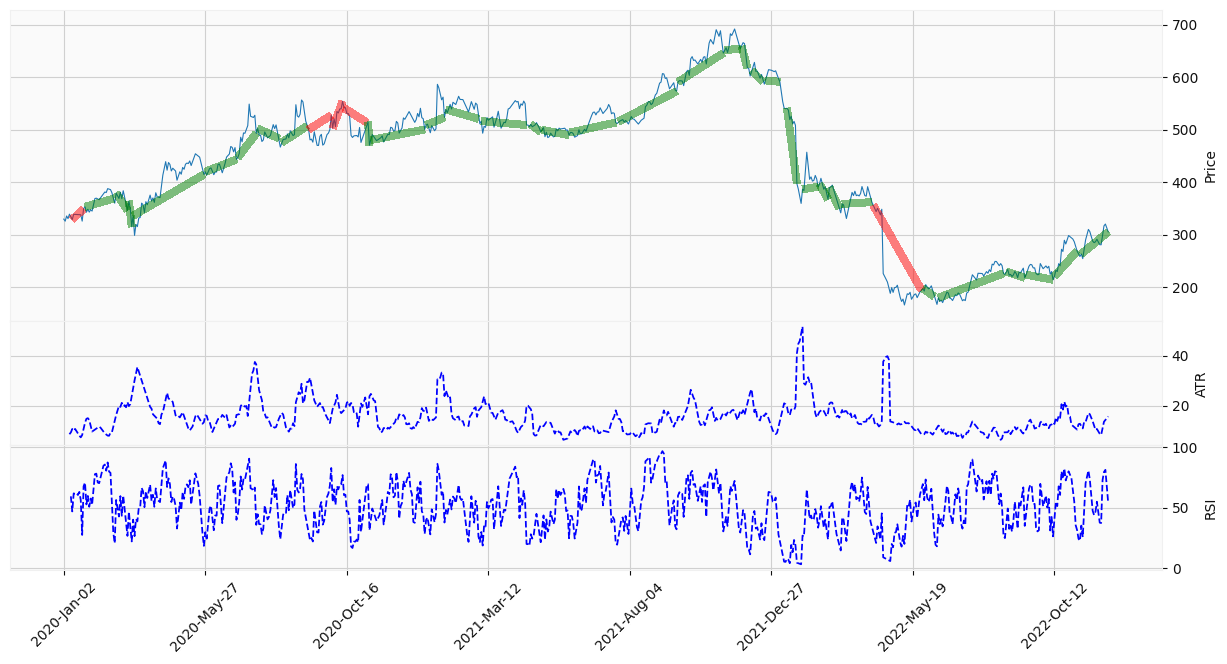

In [7]:
atr_plot = mpf.make_addplot(candles['atr'], color='blue', linestyle='--', panel=1, ylabel='ATR')
rsi_plot = mpf.make_addplot(candles['rsi'], color='blue', linestyle='--', panel=2, ylabel='RSI')

lines = []
colors = []

for op in operazioni:
    lines.append([(op[0], op[3]), (op[1], op[4])])
    colors.append('green' if op[2] == 1 else 'red')

mpf.plot(candles, addplot=[atr_plot, rsi_plot], alines=dict(alines=lines, colors=colors, linewidths=5, alpha=0.5), type='line', style='yahoo', figsize=(16, 8))